In [6]:
import numpy as np
from scipy.signal import savgol_filter
from scipy.fft import fft, fftfreq
import pandas as pd
import h5py
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import root_mean_squared_error
from scipy.signal.windows import blackman
import random

class LoadedTruckRunSet:
    
    def __init__(self, runs=[], inputs=[]):
        self.runs = runs

    def fftcat(self, varnames):
        
        fft_f = None        
        for run in self.runs:
            data = run.calcfft(varnames).to_numpy().flatten()
    
            if fft_f is None:
                fft_f = data
            else:
                fft_f = np.column_stack([fft_f, data])

        return fft_f.T
    
    def inputs(self, vars):

        inputs = []
        for run in self.runs:
            inputs.append(run.inputs.values())
        
        inputs = pd.DataFrame(inputs, None, self.runs[0].inputs.keys())

        return inputs[vars]


class LoadedTruckRun:
    
    def __init__(self, timeseries=None):
        self.timeseries = timeseries

    def calcfft(self, varnames=None):
        #returns a new dataframe with an FFT of each column in timeseries

        t = self.timeseries.index.array
        fs = 1/abs(np.mean(np.diff(t)))
        freqs = fftfreq(len(t), 1/fs)
        flength = np.argwhere(np.array(freqs)>20)[0][0]
        freqs = freqs[0:flength]

        if varnames == None:
            varnames = self.timeseries.columns.tolist()

        self.fft = pd.DataFrame(None, freqs, varnames)

        for varname in varnames:
            window = blackman(7001)
            varfft = abs(fft(self.timeseries[varname].to_numpy()*window)[:flength])
            #varfft = savgol_filter(varfft, 101, 2)
            self.fft[varname] = varfft

        return self.fft
    
    def target_data(self):
        
        targ = np.zeros((self.td.shape[0], 2))
        targ[:,0] = self.mass
        targ[:,1] = self.ix
        
        return targ
        
def load_from_matlab(path):

    runset = LoadedTruckRunSet()

    with h5py.File(path, 'r') as f:

        f2 = f['/runs']

        i = 0
        for rn in list(f2.keys()):
    
            r = f2[rn]
            rd = np.array(r)
            df = pd.DataFrame(rd[1:].T, rd[0], r.attrs['col'][1:])
            truckrun = LoadedTruckRun(df)
            truckrun.inputs = {}
            for input in r.attrs.keys():
                if input != 'col':
                    truckrun.inputs[input] = r.attrs[input][0]
                    
            if truckrun.timeseries.shape[0]==7001:
                runset.runs.append(truckrun)
    
    f.close()
    return runset

def load_from_matlab2(path):

    runset = []

    with h5py.File(path, 'r') as f:

        f2 = f['/runs']

        for rn in list(f2.keys()):
    
            r = f2[rn]
            rd = np.array(r)
            run = pd.DataFrame(rd[1:].T, rd[0], r.attrs['col'][1:])
            for input in r.attrs.keys():
                if input != 'col':
                    run.attrs[input] = r.attrs[input][0]
                    
            if run.shape[0]==7001:
                runset.append(run)
    
    f.close()
    return runset

In [2]:
def split_test_train(runs, n):

    testset = LoadedTruckRunSet([])
    trainset = LoadedTruckRunSet([])
    testids = random.sample(range(0, len(runs.runs)-1), n)
    for i in range(0, len(runs.runs)):
        if i in testids:
            testset.runs.append(runs.runs[i])
        else:
            trainset.runs.append(runs.runs[i])

    return trainset, testset

def train_and_pred(trainset, testset, datavars, inputvars):
    
    traindata = trainset.fftcat(datavars)
    traininput = trainset.inputs(inputvars)

    m = MLPRegressor(tol=1e-5, hidden_layer_sizes=(100, 60, 40, 20), max_iter=800)
    m.fit(traindata, traininput)

    testdata = testset.fftcat(datavars)
    return pd.DataFrame(data = m.predict(testdata), columns = inputvars)


In [15]:
import matplotlib.pyplot as plt


def plot_model_perf(testset, pred):
    
    vars = pred.columns
    targ = testset.inputs(vars)

    plt.style.use('dark_background')
    fig, axs = plt.subplots(len(vars), figsize=(16,4*len(vars)))
    axs = [].append(axs)
    fig.suptitle('Sensor Input: ' + str(testset.runs[0].fft.columns))
    fig.patch.set_facecolor('#1F1F1F')

    x = np.arange(len(testset.runs))

    fig.subplots_adjust(top=.94)
    for i in range(len(vars)):
        axs[i].patch.set_facecolor('#1F1F1F')
        axs[i].bar(x+0.85, targ[vars[i]], width = 0.3, color='tab:blue')
        axs[i].bar(x+1.15, pred[vars[i]], width = 0.3, color='tab:red')
        axs[i].set(ylabel=vars[i])
        axs[i].get_xaxis().set_visible(False)
        if i==0:
            axs[i].legend(['Actual', 'Predicted'])
        rms = root_mean_squared_error(targ[vars[i]], pred[vars[i]])
        axs[i].set_title('Error = ' + "{:.2f}".format(rms), y=1.0, pad=-15)

    plt.show()



In [16]:
runs = load_from_matlab('test_data/240403_data_riverbed_v1.hdf5')

for run in runs.runs:
    run.inputs['cgz-mass'] = run.inputs['cgz'] * run.inputs['mass']
    run.inputs['cgx-mass'] = run.inputs['cgx'] * run.inputs['mass']
    run.inputs['cgz (cgz-mass/mass)'] = run.inputs['cgz']


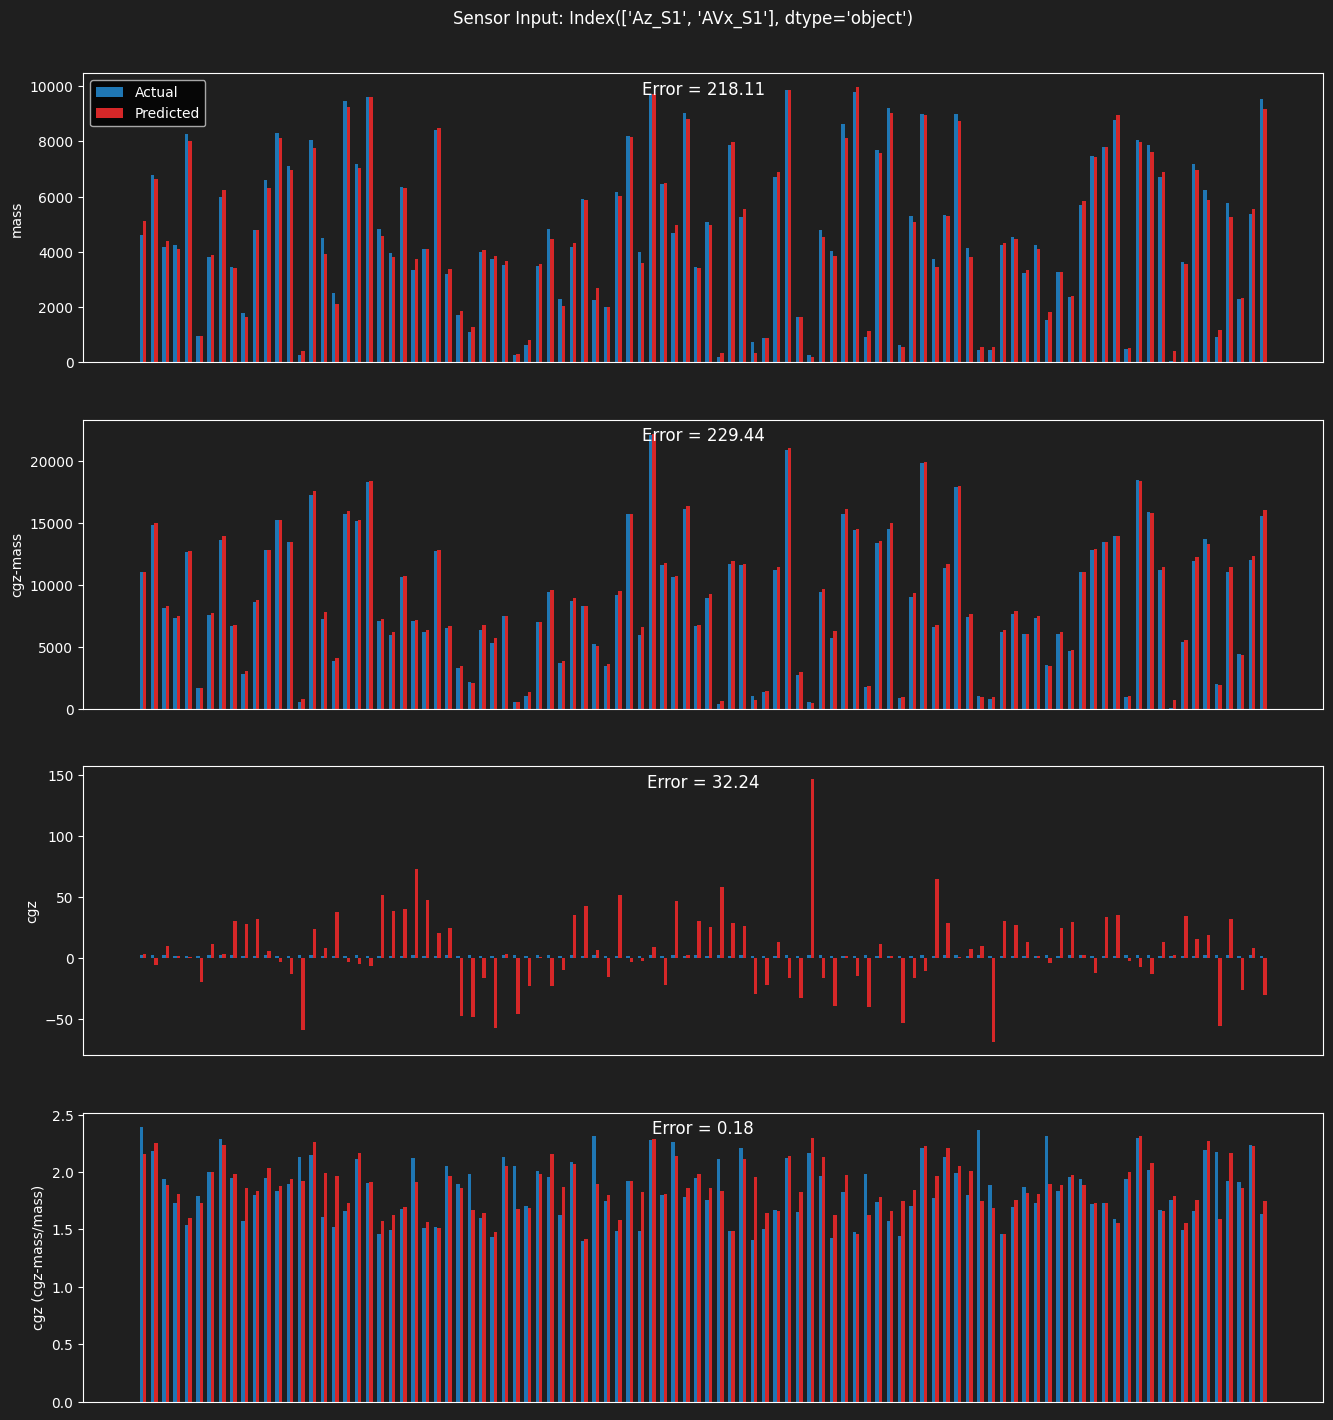

In [17]:

#datavars = ['Az_S2', 'Ay_S2', 'AVx_S2', 'Az_S5', 'Ay_S5', 'AVx_S5', 'AVy_S2']
#datavars = ['Ax_S2', 'Ay_S2', 'Az_S2', 'AVx_S2', 'AVy_S2', 'AVz_S2', 'Ax_S5', 'Ay_S5', 'Az_S5', 'AVx_S5', 'AVy_S5', 'AVz_S5']
#datavars = ['Az_S2', 'AVx_S2', 'Az_S5', 'AVx_S5']
#datavars = ['Az_S2', 'Az_S5']
datavars = ['Az_S1', 'AVx_S1']

inputvars = ['mass', 'cgz-mass', 'cgz']
#inputvars = ['mass']
#inputvars = ['mass', 'cgz']

trainset, testset = split_test_train(runs, 100)
pred = train_and_pred(trainset, testset, datavars, inputvars)

pred['cgz (cgz-mass/mass)'] = pred['cgz-mass'] / pred['mass']

plot_model_perf(testset, pred)